# <center>Tecnologias e Aplicações - TP1<center>

## <center>Criação e Treino de Redes Convolucionais<center>

### <center>Equipa<center>
    
<center> - A75569 - João Leal<center>
        
<center> - A74301 - Pedro Almeida<center>
    
<center> - A74357 - António Lopes<center>

# Introdução

&emsp;Os sinais de trânsito são responsáveis por garantir a segurança rodoviária, tanto ao condutor como ao peão, informando-os sobre quaisquer perigos ou como a condução se deve proceder, auxiliando a tomada de decisões aquando de um deslocamento. Este conjunto de sinais apresenta uma ampla gama de variações entre as suas classes em termos de cor, forma e presença de imagens ou texto. Assim, a detecção de sinais de trânsito é um problema de visão computacional de extrema relevância que apresenta várias utilidades na indústria automóvel. 
Com isto em mente, o trabalho prático que nos foi proposto passa por construir e treinar uma rede convulucional capaz de detetar as imagens de sinais de trânsito alemães e que depois classificará os sinais de trânsito não rotulados (*labeled*).
&emsp;Para isto usamos a API Keras que auxilia a construção de uma rede neuronal.

In [5]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np

import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import IPython.display as display

### Funções Auxiliares

In [6]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [32,32])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

### Load do dataset

&emsp;Para esta rede foi experimentado 3 batch sizes diferentes (16,32 e 64) mostrando melhores resultados para o batch de 32, apresentando uma *accuracy* final menor no batch de 64. Assim, seguimos com um **batch size** de **32** com imagens de **32x32**.

In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = 32

data_dir = pathlib.Path('gtsrb/train_images/')
signs = list(data_dir.glob('00001/*'))
  
classNames = np.array(os.listdir(data_dir))

AUTOTUNE = tf.data.experimental.AUTOTUNE
listset = tf.data.Dataset.list_files("gtsrb/train_images/*/*.png")
dataset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

### Informações sobre o Dataset

In [8]:
for image, label in dataset.take(1):
  print("Image shape: ", image.numpy().shape)
  
dataset_length = [i for i,_ in enumerate(dataset)][-1] + 1
print("Total images in dataset: ",dataset_length)
print("Total Classes: ",len(classNames))

Image shape:  (32, 32, 3)
Total images in dataset:  39209
Total Classes:  43


### Preparação do Dataset

In [9]:
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size = dataset_length)
dataset = dataset.batch(batch_size=BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=AUTOTUNE)
dataset = dataset.repeat()

### Load e Preparação do Dataset de teste

In [10]:
testset = tf.data.Dataset.list_files("gtsrb/test_images/*/*.png")
testset = testset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
testset = testset.batch(batch_size=BATCH_SIZE)


### Batch de Imagens

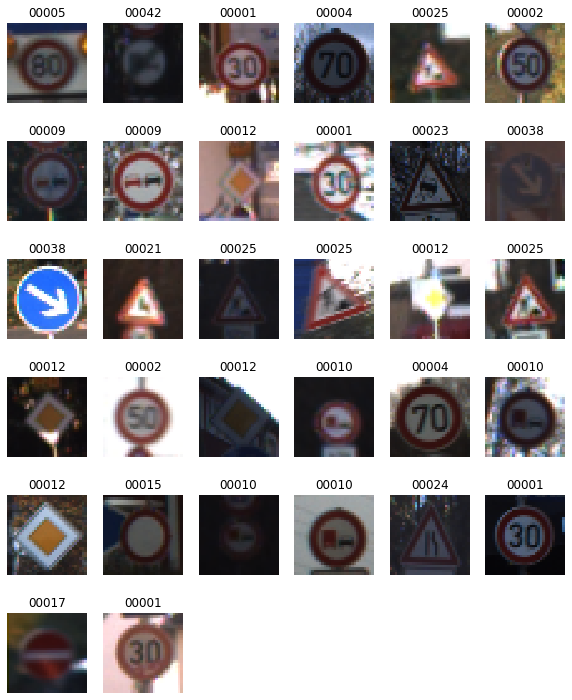

In [11]:
def show_batch(image_batch, label_batch):
  columns = 6
  rows = BATCH_SIZE / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(rows, columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')
        
        
image_batch, label_batch = next(iter(dataset))        
show_batch(image_batch, label_batch.numpy())

### Contrução da rede

&emsp; Aproveitando a rede fornecida inicialmente pelo professor, decidimos colocamr 2 layers convolucionais entre cada max pooling de modo a optimizar o trabalho sobre a imagem de modo a aumentar o reconhecimento da mesma. Acrescentamos dropout de 0.25 para fazer com que no treino da rede. Além disso, o número de filtros é tambem duplicado após o pooling por questão de optimização no treino, apresentando menores tempos e performance.

&emsp;Após o Flatten teremos apenas as 2 Layers principais onde teremos um dropout de 0.5 para a rede otimizar diversos caminhos para várias imagens. O modelo é compilado com o optimizer *Adam*, já disponibilizado na rede inicial.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam

def cnn55D3L2FC(classCount, imgSize, channels):
    model = Sequential()
    
    model.add(Conv2D(32, (5, 5), padding='same',
                     input_shape=(imgSize, imgSize, channels),
                     activation='relu'))                     
    model.add(Conv2D(32, (5, 5), activation='relu') )
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))    
    model.add(Conv2D(64, (3, 3), activation='relu') )     
    model.add(Conv2D(64, (3, 3), activation='relu') )     
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(classCount, activation='softmax'))

    
    opt = Adam(lr=0.001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ metrics.categorical_accuracy])
    return model

model = cnn55D3L2FC(43, 32, 3)


### Arquitectura da Rede


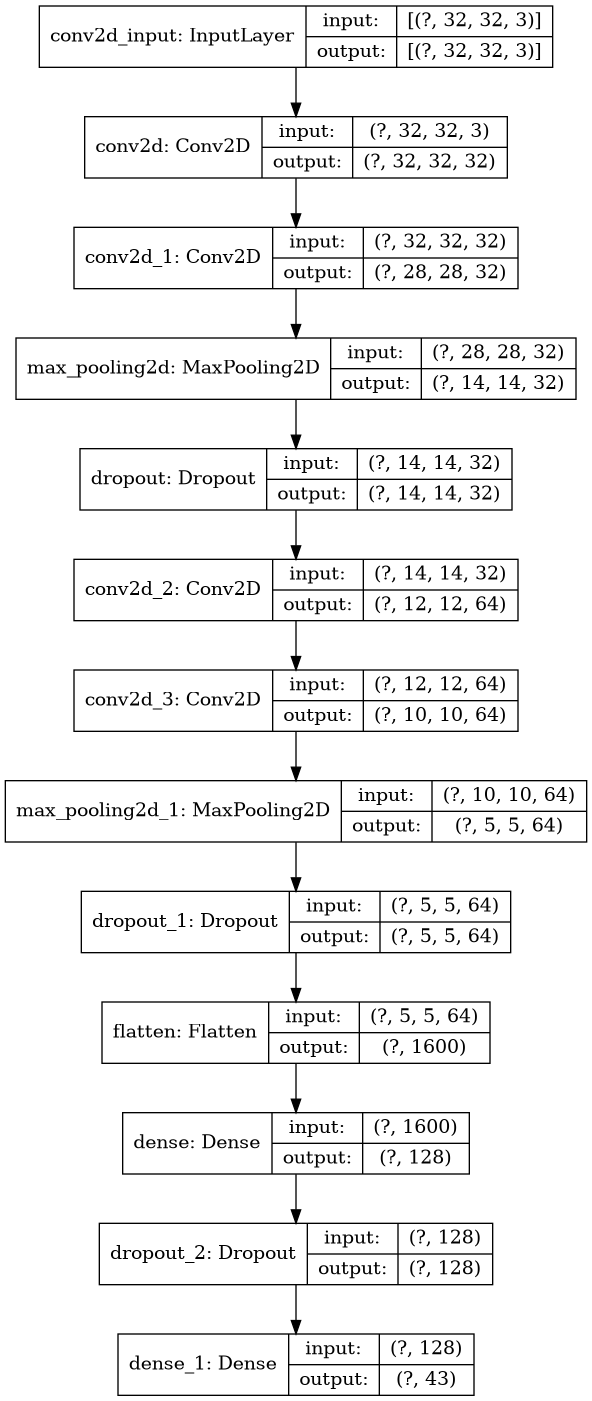

In [13]:
tf.keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

### Sumarização da Rede



In [46]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)         

### Criação do Dataset de Treino e Validação


In [47]:
train_size = int(0.8 * dataset_length)
val_size = int(0.2 * dataset_length)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(val_size)

### Train do modelo

In [48]:
history = model.fit(dataset, steps_per_epoch = 0.8*dataset_length/BATCH_SIZE,
          epochs=20, validation_data = val_dataset, validation_steps= 0.2*dataset_length/BATCH_SIZE)

Train for 980.225 steps, validate for 245.05625 steps
Epoch 1/17
981/980 [==============================] - 163s 166ms/step - loss: 1.5665 - categorical_accuracy: 0.5492 - val_loss: 0.2705 - val_categorical_accuracy: 0.9374
Epoch 2/17
981/980 [==============================] - 162s 165ms/step - loss: 0.3871 - categorical_accuracy: 0.8780 - val_loss: 0.0866 - val_categorical_accuracy: 0.9779
Epoch 3/17
981/980 [==============================] - 163s 166ms/step - loss: 0.2208 - categorical_accuracy: 0.9309 - val_loss: 0.0336 - val_categorical_accuracy: 0.9919
Epoch 4/17
981/980 [==============================] - 163s 166ms/step - loss: 0.1658 - categorical_accuracy: 0.9501 - val_loss: 0.0307 - val_categorical_accuracy: 0.9920
Epoch 5/17
981/980 [==============================] - 160s 163ms/step - loss: 0.1346 - categorical_accuracy: 0.9596 - val_loss: 0.0231 - val_categorical_accuracy: 0.9930
Epoch 6/17
981/980 [==============================] - 162s 165ms/step - loss: 0.1149 - categoric

### Plot do treino resultante

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


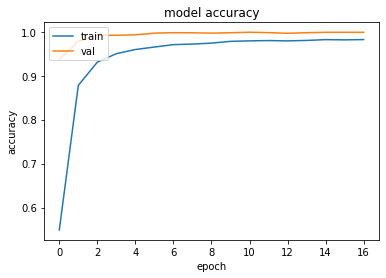

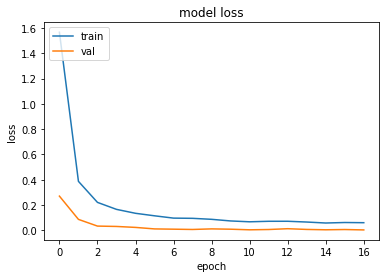

In [49]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Avaliação do Modelo


In [50]:
model.evaluate(testset)

395/395 [==============================] - 21s 53ms/step - loss: 0.1427 - categorical_accuracy: 0.9747


[0.1426839270135967, 0.97474265]

### Conclusão

&emsp;O resultado obtido é um bocado acima do expectado e definido como objetivo para este trabalho (**97\%**), contudo mantém-se a questão de como podemos fazer com que a performance do modelo melhore. Uma possibilidade seria reduzir a complexidade da rede através da conversão das imagens para grayscale e augmentação de data, podendo também definir mais layers de forma a recolher mais *features* das imagens. 
&emsp;Contudo, obtendo um resultado de **97.4\%** é agradável numa primeira fase e expectamos alcançar os 99\% +, aplicando as técnias anteriormente referidas no próximo trabalho prático